# Maximum Entropy Inverse Reinforcement Learning (MaxEnt IRL)

In behavior cloning (BC), only the learner policy is trained by using expert demonstration.

Inverse Reinforcement Learning (IRL) is a method to learn a cost function, i.e, recovering the unknown reward function from expert's behaviors.

For the first example of IRL, I'll show you Maximum Entropy Inverse Reinforcement Learning by step-by-step manner in this notebook.

*(back to [index](https://github.com/tsmatz/imitation-learning-tutorials/))*

## Why Maximum Entropy Inverse Reinforcement Learning ? (Short history)

The first approach for IRL (apprenticeship learning) is proposed by [[Abbeel and Ng, 2004](https://ai.stanford.edu/~ang/papers/icml04-apprentice.pdf)], which is based on **feature expectation matching**.<br>
Feature expectation matching assumes that the reward is linear to the feature of trajectory, i.e, $\verb|reward| = \mathbf{w}^T \cdot \phi(\tau)$, where $\phi(\tau)$ is a trajectory-to-feature mapping function (i.e, the feature of trajectory).

> Note : We will discuss IRL with nonlinear rewards in [GAIL example](./05_gail.ipynb).

In this assumption, the idea of feature expectation matching finds the optimal policy $\pi^L$ in the training, which satisfies :

$\displaystyle \mathbb{E}_{\pi^L}[\phi(\tau)] = \mathbb{E}_{\pi^{\ast}}[\phi(\tau)]$

where

- $\pi^{\ast}$ is the expert policy
- $\mathbb{E}_{\pi^L}[\phi(\tau)]$ is the expected feature under the policy $\pi^L$
- $\mathbb{E}_{\pi^{\ast}}[\phi(\tau)]$ is the expected feature under the expert policy $\pi^{\ast}$

To obtain the solution, [[Ratliff et al., 2006](https://papers.nips.cc/paper/3154-boosting-structured-prediction-for-imitation-learning)] has proposed **Maximum-Margin Planning (MMP)** method, which method is to find a cost function to maximize the difference between the optimal policy and others.<br>
These methods are based on applying margin maximization. (See [my old post](https://tsmatz.wordpress.com/2020/06/01/svm-and-kernel-functions-mathematics/) for the fundamental idea of margin maximization in classification.)

This approach works well, when it's clearly better than alternatives. The obtained reward function, however, may be sub-optimal (i.e, ill-posed) in complex cases.<br>
To address this problem, [[Brian et al., 2008](https://cdn.aaai.org/AAAI/2008/AAAI08-227.pdf)] has proposed to apply the maximum entropy principle - i.e, **Maximum Entropy Inverse Reinforcement Learning** (MaxEnt IRL).

In information theory, **entropy** is the value of average amount of information to represent its distribution, and it's known that the stable probability distribution (i.e, appropriate randomness) leads to the large entropy. (See [[Christopher M. Bishop, Microsoft](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)].)<br>
Maximum Entropy Inverse Reinforcement Learning is a method to find the optimal solution by maximizing the entropy, while meeting the other optional conditions.<br>
The problem can be solved by applying Lagrange multipliers.

## Overview of Maximum Entropy Inverse Reinforcement Learning method

Now let's briefly follow this method along with the original paper [[Brian et al., 2008](https://cdn.aaai.org/AAAI/2008/AAAI08-227.pdf)].

First, we consider to find a policy $p()$ to maximize the entropy :

$\displaystyle \sum p(\tau) \log \frac{1}{p(\tau)}$

subjects to the following constraint (feature expectation matching constraint) :

$\displaystyle \mathbb{E}_{\pi^L}[\phi(\tau)] = \mathbb{E}_{\pi^{\ast}}[\phi(\tau)]$

By applying Lagrangian multiplier $\theta$, this distribution follows :

$\displaystyle p(\tau) \propto \exp(\theta^T \cdot \phi(\tau)) $

> Note : See Wikipedia "[Maximum entropy probability distribution](https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution)".

I note that Lagrangian multiplier $\theta$ becomes a reward weight, and the policy will then be given by using $\theta$.

Above equation is trajectory view of equation, but now let's switch to the state-action's view.

When it's finite time horizon, the feature of trajectory $\phi(\tau)$ is the sum of state's features, i.e $\phi(\tau) = \sum_{s_i \in \tau} \phi(s_i)$. (Because $\verb|[reward of trajectory|\;\tau\verb|]| = \sum_{s_i \in \tau} \verb|[reward of state|\;s_i\verb|]|$ in feature expectation.)<br>
Then it can be written by :

$\displaystyle p(\tau) \propto \exp(\theta^T \cdot \sum_{s_i \in \tau} \phi(s_i)) $

> Note : As I have mentioned in [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md), here we assume the time horizon is finite (which has 200 time-steps).<br>
> If it's infinite time horizon, apply the discounted reward's weights for features. (In this example, I use reward's weights without discount.)

Because $\sum_{\tau} p(\tau) = 1$, this then leads to the following equation:

$\displaystyle p(\tau) = \frac{1}{Z(\theta)} \exp(\theta^T \cdot \sum_{s_i \in \tau} \phi(s_i))$

where $Z(\theta)=\sum_{\tau} \exp(\theta^T \cdot \sum_{s_i \in \tau} \phi(s_i))$

You should remember that our environment has stochastic (non-deterministic) transition.<br>
The above equation is then rewritten as follows. :

$\displaystyle p(\tau) = \frac{1}{Z(\theta)} \exp(\theta^T \cdot \sum_{s_i \in \tau} \phi(s_i)) \prod_{s_{t+1},a_t,s_t \in \tau} p(s_{t+1} | s_t, a_t)$

where $Z(\theta)=\sum_{\tau} \exp(\theta^T \cdot \sum_{s_i \in \tau} \phi(s_i)) \prod_{s_{t+1},a_t,s_t \in \tau} p(s_{t+1} | s_t, a_t)$

Now we should find the optimal $\theta$ to maximize the log-likelihood of above formula with demonstrated expert's examples. :

$ \displaystyle \theta^{\ast} = \arg \max_{\theta} L(\theta) = \arg \max_{\theta} \sum_{\verb|expert's examples|} \log p(\tau) $

> Note : See [here](https://tsmatz.wordpress.com/2017/08/30/regression-in-machine-learning-math-for-beginners/) for duality between maximizing likelihood and maximizing entropy.

Because this function is convex, the optimal $\theta$ can be obtained using gradient-based optimization. In this case, the gradient is given by the difference between expert's (empirical) features and expected features (which is obtained by using current $\theta$) as follows. :

$ \displaystyle \nabla L(\theta) = \mathbb{E}_{\pi^{\ast}}[\phi(\tau)] - \sum_{\tau} p(\tau) \phi(\tau) $

Now we consider to get this gradient by state-action notations.<br>
The first term in above equation is $\mathbb{E}_{\pi^{\ast}}[\phi(\tau)] = \mathbb{E}_{\pi^{\ast}}[\sum_{s_i \in \tau} \phi(s_i)]$, and we can easily get the empirical expectation by the average of expert's demostrations.<br>
The second term in above equation is $\sum_{\tau} p(\tau) \phi(\tau) = \sum_{s_i} D_{s_i} \phi(s_i)$, where $D_{s_i}$ is the visitation frequency which can be obtained by using current $\theta$.

In order to get $D_{s_i}$, the most straight-forward approach is to enumerate each possible paths.<br>
But this approach is computationally expensive, and we now estimate by applying the following algorithm with large $N$ to get $D_{s_i}$. (This algorithm
approximates the state frequencies for the infinite time horizon using a large fixed time horizon $N$.) :

<ins>Backward pass</ins>

1. Set $Z_{s_{\verb|goal|}} = 1$ and $Z_{s_{\verb|others|}} = 0$
2. Compute the following for $N$ iterations. This will recursively (by backward from goal to initial state) fill $Z_s$ values. :
    - $Z_{s_i, a_j} = \sum_{k} p(s_k | s_i, a_j) \exp(\theta^T \cdot \phi(s_i)) Z_{s_k} \;\; (\forall i, j)$
    - then $Z_{s_i} = \sum_j Z_{s_i, a_j} \;\; (\forall i)$

<ins>Local action probability computation</ins>

3. Compute $p(a_j | s_i) = \frac{Z_{s_i, a_j}}{Z_{s_i}} \;\; (\forall i, j)$

<ins>Forward pass</ins>

4. Set $D_{s_i, 1} = p(s_i \verb| is initial state|) \;\; (\forall i)$
5. Compute the following for $t=1$ to $N$. This will recursively (by forward from $t=1$ to $N$) fill $D$ values. :
    - $D_{s_i, t+1} = \sum_k \sum_j D_{s_k, t} p(a_j | s_k) p(s_i | a_j, s_k) \;\; (\forall i)$

> Note : In our example, $ p(s_i \verb| is initial state|) $ may simply be $\frac{1}{\verb| the number of possible initial states|}$.

<ins>Summing frequencies</ins>

6. Compute $D_{s_i} = \sum_t D_{s_i, t} \;\; (\forall i)$

Now we have got $\nabla L(\theta)$ and we can then apply gradient method to get optimal $\theta$.

To get the optimal policy $\pi^L$ with the trained parameters $\theta$, you can reuse above algorithm and then get $p(a_j | s_i)$.

It's worth noting that this method assumes that the state transition distribution $p(s_i | a_j, s_k)$ is known, which is not the case in many robotic applications.

> Note : The following work, **Maximum Causal Entropy Inverse Reinforcement Learning** method [[Ziebart et al., 2010](https://www.cs.cmu.edu/~bziebart/publications/maximum-causal-entropy.pdf)], addresses the drawbacks of Maximum Entropy Inverse Reinforcement Learning by applying the principle of maximum causal entropy, instead of applying the principle of maximum entropy.<br>
> In this repository, Maximum Causal Entropy Inverse Reinforcement Learning is out of scope.

## Implementation

Firstly, our example (GridWorld) obviously satisfies that the reward is linearly dependent on the state's feature.<br>
Hence we can apply Maximum Entropy IRL method on our example.

Now let's implement above algorithm.

> Note : To speed up computation, I'll implement operations with PyTorch tensors.

### 1. Restore environment and load expert's data

Before we start, we need to install the required packages.

In [ ]:
!pip install torch numpy matplotlib

Firstly, I restore GridWorld environment from JSON file.

For details about this environment, see [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md).

> Note : See [this script](./00_generate_expert_trajectories.ipynb) for generating the same environment.

In [1]:
import numpy as np
import random

GRID_SIZE = 50
MAX_TIMESTEP = 200

class GridWorld:
    """
    This environment is motivated by the following paper.
    https://proceedings.mlr.press/v15/boularias11a/boularias11a.pdf

    - It has 50 x 50 grids (cells).
    - The agent has four actions for moving in one of the directions of the compass.
    - If ```transition_prob``` = True, the actions succeed with probability 0.7,
      a failure results in a uniform random transition to one of the adjacent states.
    - A reward of 10 is given for reaching the goal state, located on the bottom-right corner.
    - For the remaining states,
      the reward function was randomly set to 0 with probability 2/3
      and to −1 with probability 1/3.
    - If the agent moves across the border, it's given the fail reward (i.e, reward=`-1`).
    - The initial state is sampled from a uniform distribution.
    """

    def __init__(self, reward_map, valid_states, transition_prob=True):
        """
        Initialize class.

        Parameters
        ----------
        reward_map : float[GRID_SIZE * GRID_SIZE]
            Reward for each state.
        valid_states : list(int[2])
            List of states, in which the agent can reach to goal state without losing any rewards.
            Each state is a 2d vector, [row, column].
            When you call reset(), the initial state is picked up from these states.
        transition_prob : bool
            True if transition probability (above) is enabled.
            False when we generate an expert agent without noise.
        """
        self.reward_map = np.array(reward_map)
        self.valid_states = np.array(valid_states)
        self.transition_prob = transition_prob

    def reset(self):
        """
        Randomly, get initial state (single state) from valid states.

        Returns
        ----------
        state : int
            Return the picked-up state id.
        """
        # initialize step count
        self.step_count = 0
        # pick up sample of valid states
        state_2d = random.choice(self.valid_states)
        # convert 2d index to 1d index
        state_1d = state_2d[0] * GRID_SIZE + state_2d[1]
        # return result
        return state_1d

    def step(self, action, state, trans_state_only=False):
        """
        Take action, proceed step, and return the result.

        Parameters
        ----------
        action : int
            Actions to take
            (0=UP 1=DOWN 2=LEFT 3=RIGHT)
        state : int
            Current state id.
        trans_state_only : bool
            Set TRUE, when you call to get next state by stateless without reset()

        Returns
        ----------
        new-state : int
            New state id.
        reward : int
            The obtained reward.
        done : bool
            Flag to check whether it terminates.
        """
        # if transition prob is enabled, apply transition
        if self.transition_prob:
            # the action succeeds with probability 0.7
            prob = [.1]*4
            prob[action] *= 7.0
            action_onehot = np.random.multinomial(1, prob)
        else:
            action_onehot = np.zeros(4, dtype=int)
            action_onehot[action] += 1
        # get 2d state
        mod, reminder = divmod(state, GRID_SIZE)
        state_2d = np.array([mod, reminder])
        # move state
        # (0=UP 1=DOWN 2=LEFT 3=RIGHT)
        up_and_down = action_onehot[1] - action_onehot[0]
        left_and_right = action_onehot[3] - action_onehot[2]
        new_state = state_2d + np.array([up_and_down, left_and_right])
        # set reward
        reward = 0.0
        if not(trans_state_only):
            if (new_state[0] < 0) or (new_state[0] >= GRID_SIZE) or (new_state[1] < 0) or (new_state[1] >= GRID_SIZE):
                # if location is out of border, set reward=-1
                reward -= 1.0
            else:
                # if succeed, add reward of current state
                state_1d = new_state[0] * GRID_SIZE + new_state[1]
                reward += self.reward_map[state_1d]
        # correct location
        new_state = np.clip(new_state, 0, GRID_SIZE-1)
        # return result
        if trans_state_only:
            return new_state[0] * GRID_SIZE + new_state[1]
        else:
            self.step_count += 1
            return new_state[0] * GRID_SIZE + new_state[1], reward, (new_state[0]==GRID_SIZE-1 and new_state[1]==GRID_SIZE-1) or (self.step_count==MAX_TIMESTEP)

In [2]:
import json

with open("gridworld.json", "r") as f:
    json_object = json.load(f)
    env = GridWorld(**json_object, transition_prob=False)

Load expert's data (demonstrations) which is saved in ```./expert_data``` folder in this repository.

> Note : See [this script](./00_generate_expert_trajectories.ipynb) for generating expert dataset.

In [3]:
import pickle

dest_dir = "./expert_data"
checkpoint_file = "ckpt0.pkl"

# load expert data from pickle
with open(f"{dest_dir}/{checkpoint_file}", "rb") as f:
    exp_data = pickle.load(f)
exp_states = exp_data["states"]
exp_actions = exp_data["actions"]
timestep_lens = exp_data["timestep_lens"]

### 2. Get expert's feature expectation $\mathbb{E}_{\pi^{\ast}}[\phi(\tau)]$

We can easily get the expert's feature expectation (i.e, the empirical expectation) by the average of expert's demostrations as follows.

$\displaystyle \mathbb{E}_{\pi^{\ast}}[\phi(\tau)] = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{s \in \tau} \phi(s)$

I note that expert's dataset doesn't have final state, but the expert's feature expectation needs the whole states (especially, goal state).<br>
Hence I add the final state in each trajectory.

> Note : As you can see below, the expert's actions are not used in this algorithm. (It only uses the features of expert's states.)<br>
> The algorithm of Maximum Entropy IRL knows the transition probability $p(s_i | a_j, s_k)$ by taking action $a_j$ in state $s_k$, and it can then estimate the actions taken by the expert.

In [4]:
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

STATE_SIZE = GRID_SIZE*GRID_SIZE
ACTION_SIZE = 4

# initialize
current_timestep = 0
sum_of_features = np.zeros(STATE_SIZE)

# loop all trajectories in demonstration
for timestep_len in timestep_lens:
    # pick up state's id array in a single trajectory
    states_in_traj = exp_states[current_timestep:current_timestep+timestep_len]

    # add final state (see above)
    final_action = exp_actions[current_timestep+timestep_len - 1]
    final_state = env.step(final_action, states_in_traj[-1], trans_state_only=True)
    states_in_traj = np.append(states_in_traj, final_state)

    # convert into state's features (i.e, one-hot)
    traj_features = np.zeros((states_in_traj.size, GRID_SIZE*GRID_SIZE), dtype=int)
    traj_features[np.arange(states_in_traj.size), states_in_traj] = 1

    # sum up
    sum_of_features += np.sum(traj_features, axis=0)

    # proceed to next trajectory
    current_timestep += timestep_len

# divide by the number of trajectories
feature_exp = sum_of_features / len(timestep_lens)
feature_exp = torch.from_numpy(feature_exp).to(device)

### 3. Make transition probabilities

As I have mentioned above, the algorithm (Maximum Entropy IRL learner) should know the translation probabilities.

Now I generate the numpy array with shape $(i,j,k)$ of transition probabilities $p(s_k | s_i, a_j)$, where $i, k = 0,1,\ldots,2499$ and $j=0,1,2,3$.

In this example, the environment has deterministic transition, where $p(s_k | s_i, a_j ) = 1.0$ for one successor state and $0.0$ for all others.

> Note : You can apply stochastic probability in this environment by setting ```transition_prob=True``` in constructor - in which, the action succeeds with probability `0.7`, a failure results in a uniform random transition (i.e, `0.1`, `0.1`, `0.1` respectively) to one of the adjacent states. (Change [this script](./00_generate_expert_trajectories.ipynb) and recreate expert's data.)<br>
> If you apply the stochastic transition probability, you should set the corresponding probabilities ($0 \lt p \lt 1$) in below matrics instead.

In [5]:
tran_probs = np.zeros((STATE_SIZE, ACTION_SIZE, STATE_SIZE))

for s in range(STATE_SIZE):
    for a in range(ACTION_SIZE):
        next_s = env.step(a, s, trans_state_only=True)
        tran_probs[s, a, next_s] = 1.0

tran_probs = torch.from_numpy(tran_probs).to(device)

### 4. Perform backward pass

Now we generate a function to perform the following backward pass.

1. Set $Z_{s_{\verb|goal|}} = 1$ and $Z_{s_{\verb|others|}} = 0$
2. Compute the following for $N$ iterations. This will recursively (by backward from goal to initial state) fill $Z_s$ values. :
    - $Z_{s_i, a_j} = \sum_{k} p(s_k | s_i, a_j) \exp(\theta^T \cdot \phi(s_i)) Z_{s_k} \;\; (\forall i, j)$
    - then $Z_{s_i} = \sum_j Z_{s_i, a_j} \;\; (\forall i)$

To speed up computation, here I implement the procedure in each iteration by matrix operations of torch tensors.

In [6]:
# create feature's matrix for all states
all_features = torch.zeros(STATE_SIZE, STATE_SIZE).to(device)
all_features[torch.arange(STATE_SIZE), torch.arange(STATE_SIZE)] = 1.0

def backward_pass(theta, N, tran_probs):
    # initialize Z_s
    z_s = torch.zeros(STATE_SIZE).to(device)
    z_s[-1] = 1.0

    # loop N iterations
    for n in range(N):

        # compute exp(\theta^T \cdot \phi(s_i))
        all_states_exp = torch.exp(torch.matmul(theta, torch.transpose(all_features, 0, 1))) ### shape (i)

        # sum up for all transition state s_k
        x = torch.mul(tran_probs, z_s) ### shape (i,j,k)
        x = torch.sum(x, dim=2) ### shape (i,j)
        x = torch.mul(x, torch.unsqueeze(all_states_exp, dim=-1)) ### shape (i,j)
        z_sa = x

        # compute Z_s
        z_s = torch.sum(z_sa, dim=1)

    # return result
    return z_s, z_sa

### 5. Perform forward pass

Next we generate a function to perform the following forward pass.

1. Set $D_{s_i, 1} = p(s_i \verb| is initial state|) \;\; (\forall i)$
2. Compute the following for $t=1$ to $N$. This will recursively (by forward from $t=1$ to $N$) fill $D$ values. :
    - $D_{s_i, t+1} = \sum_k \sum_j D_{s_k, t} p(a_j | s_k) p(s_i | a_j, s_k) \;\; (\forall i)$

In this example, the above $p(s_i \verb| is initial state|)$ is simply $\frac{1}{\verb| the number of possible initial states|}$.

The above $p(a_j | s_k)$ is a learner probability to take action $a_j$ in the state $s_k$, which is induced by the previous backward's results. (The following ```action_probs``` is a ```STATE_SIZE``` * ```ACTION_SIZE``` matrix, in which each element holds this probability.)

In [7]:
# generate list of possible initial state's id
valid_states_2d = env.valid_states
valid_states_1d = valid_states_2d[:,0] * GRID_SIZE + valid_states_2d[:,1]
valid_states_1d = torch.from_numpy(valid_states_1d).to(device)

def forward_pass(N, tran_probs, action_probs):
    # initialize D_{s,t}
    d_st = torch.zeros(STATE_SIZE, N).to(device)

    # set D_{s,1} = p(initial state)
    d_st[valid_states_1d,0] = 1.0 / valid_states_1d.size(dim=0)

    # compute in t=2, ... ,N
    for t in range(1, N):
        tran_probs_T = torch.transpose(tran_probs, 0, 2) ### shape (i,j,k)
        action_probs_T = torch.transpose(action_probs, 0, 1) ### shape (j,k)
        x_T = torch.mul(tran_probs_T, action_probs_T) ### shape (i,j,k)
        x_T = torch.mul(x_T, d_st[:,t-1]) ### shape (i,j,k)
        d_st[:,t] = torch.sum(torch.sum(x_T, dim=-1), dim=-1) ### shape (i)

    # return results
    return d_st

### 6. Evaluate with random probabilities

For comparison, now I evaluate the obtained reward by using random probabities.

In this game, the maximum episode's reward without losing any rewards is ```10.0```. (See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for game rule in this environment.)<br>
As you can see below, it has low average of rewards.

In [8]:
def evaluate(action_probs, eval_num):
    score_list = []
    for i in range(eval_num):
        score = 0
        done = False
        s = env.reset()
        while not done:
            prob = action_probs[s,:]
            a = torch.multinomial(prob, num_samples=1)
            a = a.squeeze().tolist()
            s, r, done = env.step(a, s)
            score += r
        score_list.append(score)
    return sum(score_list) / len(score_list)

action_probs = torch.ones(STATE_SIZE, ACTION_SIZE) / ACTION_SIZE
avg_reward = evaluate(action_probs, 300)
print(f"Estimated rewards (random pick-up): {avg_reward}")

Estimated rewards (random pick-up): -68.20333333333333


### 7. Put it all together (Optimize $\theta$)

Now let's put it all together and then optimize parameter $\theta$ by the following steps.

1. Perform backward pass to get $Z_{s_i}$ and $Z_{s_i, a_j}$.
2. Compute action probabilities. : $p(a_j | s_i) = \frac{Z_{s_i, a_j}}{Z_{s_i}}$
3. Perform forward pass to get $D_{s_i, t}$.
4. Compute $D_{s_i} = \sum_t D_{s_i, t}$.
5. Compute $\nabla L(\theta) = \mathbb{E}_{\pi^{\ast}}[\phi(\tau)] - \sum_{s_i} D_{s_i} \phi(s_i)$
6. Update $\theta$.
7. Back again to 1 and loop until $\nabla L(\theta)$ becomes sufficiently small.

In this example, we update $\theta$ with direct updates by the gradient (not using backprop) with 600 training iterations.

As you can see below, the average reward becomes high, and the parameter is optimized.

> Note : Because I try to maximize likelihood (not minimize loss), I then apply **gradient ascent**, instead of gradient descent.<br>
> In [original paper](https://cdn.aaai.org/AAAI/2008/AAAI08-227.pdf), exponential gradient is applied in experimentation, but here I simply apply basic gradient optimization.

In [9]:
learning_rate = 0.2
warm_up = 250
decay = 0.001
target = 0.1

N1 = 100
N2 = 70

# initialize parameters
theta = torch.empty(STATE_SIZE).to(device)
torch.nn.init.uniform_(theta, a=0.0, b=1.0)

for iter_num in range(600):
    # 1. perform backward pass (with current theta)
    z_s, z_sa = backward_pass(theta, N1, tran_probs)

    # 2. compute action probabilities
    action_probs = z_sa / z_s.unsqueeze(dim=-1).expand(-1, ACTION_SIZE)

    # 3. perform forward pass
    d_st = forward_pass(N2, tran_probs, action_probs)

    # 4. compute d_s
    d_s = torch.sum(d_st, dim=1)

    # 5. compute nabla
    x_T = torch.mul(d_s, torch.transpose(all_features, 0, 1))
    x = torch.transpose(x_T, 0, 1)
    x = torch.sum(x, dim=0)
    nabla = feature_exp - x

    # (output logs)
    t_mean = torch.mean(torch.abs(nabla)).tolist()
    t_max = torch.max(torch.abs(nabla)).tolist()
    print("nabla - average: {:1.5f} max: {:1.5f} (lr: {:1.4f})".format(t_mean, t_max, learning_rate), end="\r")
    if iter_num % 30 == 29:
        avg_reward = evaluate(action_probs, 300)
        print("\nestimated reward is {:.4f}.".format(avg_reward))

    # 6. update theta (see above note)
    theta += nabla * learning_rate
    if iter_num >= warm_up:
        learning_rate = max(learning_rate - decay, target) # apply linear scheduling

print("\nDone")

nabla - average: 0.01298 max: 0.73423 (lr: 0.2000)
estimated reward is -5.88.
nabla - average: 0.00985 max: 0.77563 (lr: 0.2000)
estimated reward is -2.7667.
nabla - average: 0.00865 max: 0.79080 (lr: 0.2000)
estimated reward is -2.2467.
nabla - average: 0.00807 max: 0.80195 (lr: 0.2000)
estimated reward is -1.9467.
nabla - average: 0.00756 max: 0.72023 (lr: 0.2000)
estimated reward is -0.06.
nabla - average: 0.00754 max: 0.84869 (lr: 0.2000)
estimated reward is -1.4534.
nabla - average: 0.00708 max: 0.66894 (lr: 0.2000)
estimated reward is 0.7733.
nabla - average: 0.00722 max: 0.85359 (lr: 0.2000)
estimated reward is -0.9333.
nabla - average: 0.00672 max: 0.70672 (lr: 0.1810)
estimated reward is 0.3133.
nabla - average: 0.00623 max: 0.60259 (lr: 0.1510)
estimated reward is 2.1633.
nabla - average: 0.00540 max: 0.15508 (lr: 0.1210)
estimated reward is 3.6166.
nabla - average: 0.00532 max: 0.07696 (lr: 0.1000)
estimated reward is 3.4733.
nabla - average: 0.00528 max: 0.07640 (lr: 0.1000

## Show results

The following shows you which direction has high probability in the trained parameters.<br>
In this environment, the state in right-bottom corner is a goal state. (See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for game rule in this environment.)<br>
As you can see below, the parameters are optimized to reach to the goal.

I note that the gray-colored cells are valid states, in which the agent can reach to the goal without losing any rewards.<br>
In this environment, the initial state is picked up from these gray-colored states.

In [10]:
from IPython.display import HTML, display

with torch.no_grad():
    html_text = "<table>"
    for row in range(GRID_SIZE):
        html_text += "<tr>"
        for col in range(GRID_SIZE):
            if ([row, col] in env.valid_states.tolist()) or ([row, col] in [[49, 49]]):
                html_text += "<td bgcolor=\"gray\">"
                #
                # get direction
                #
                state_id = row * GRID_SIZE + col
                prob = action_probs[state_id,:]
                index = torch.argmax(prob).tolist()
                #
                # show direction
                #
                if index == 0:
                    html_text += "&#x2191;" # up
                elif index == 1:
                    html_text += "&#x2193;" # down
                elif index == 2:
                    html_text += "&#x2190;" # left
                elif index == 3:
                    html_text += "&#x2192;" # right
            else:
                html_text += "<td>"
            html_text += "</td>"
        html_text += "</tr>"
    html_text += "</table>"

display(HTML(html_text))

,,,,,,→,→,→,→,↓,↓,,↓,,,,,←,,←,,←,→,→,,↓,↓,↓,,,,,←,←,↓,↓,,,,,,,,,,,,,
,,,,,,→,,→,→,→,↓,↓,↓,↓,←,←,←,←,←,←,,,,→,,→,↓,←,←,←,,←,,←,,↓,,,,,,,,,,,,,
,,,,,,→,,→,,→,→,↓,←,←,←,←,,←,←,,←,←,,→,→,→,↑,←,←,←,,←,←,,↓,↓,,,↓,↓,,,,,,,,,
,,,→,,,→,→,,→,,→,↑,←,←,,←,,←,,,,←,←,,,↑,↑,,↑,←,←,←,←,↓,↓,↓,←,↓,↓,↓,,,,,,,,,
,,,→,→,→,→,→,→,→,→,→,↑,↑,↑,←,←,←,←,,,←,,←,→,→,↑,↑,↑,↑,↑,↑,←,←,↓,,↓,,↓,↓,↓,,,,,,,,,
,,,→,→,,→,,→,↑,,↑,↑,,↑,↑,,,↑,←,,←,←,←,,→,↑,↑,↑,,,↑,↑,,↓,,,,,↓,←,,,,,,,,,
,,↓,→,→,→,→,→,→,↑,↑,↑,,,,↑,↑,←,←,←,,,↓,←,,,↑,↑,,,,,→,→,→,↓,←,←,←,,,,,,,,,,,
→,→,↓,→,,→,↑,↑,,↑,↑,↑,↑,,↑,↑,,,↑,←,,↓,←,,←,↑,,↑,↑,↑,,,↓,↓,,↓,,↓,,,,,,,,,,,,
→,→,→,→,→,→,→,→,↑,↑,,,↑,,↑,↑,,↑,↑,,,↓,←,←,←,←,↑,,↑,↓,↓,,,,,,,↓,,,,,,,,,,,,
→,→,↑,,→,,→,↓,,,↑,↑,,↑,↑,↑,←,↑,→,↓,←,←,,,,←,,←,↓,→,→,→,→,↓,↓,↓,←,,,,,,,,,,,,,
→,→,→,→,→,,→,→,→,↓,,↑,↑,,↑,↓,↓,,→,↓,←,,←,←,,←,←,←,,,↓,,,→,↓,←,←,←,,,,,,,,,,,,↓


The following shows a heatmap for the value $\theta^T \cdot \phi(s_i)$.<br>
As you can see below, the states on the path toward the goal state are hot in this map.

> Note : In the area of the following yellow spot (extremely hot), the expert doesn't also work well (hence the expert agent will walk around this area in order not to lose the reward), and then the visited frequencies in this area is becoming so large.

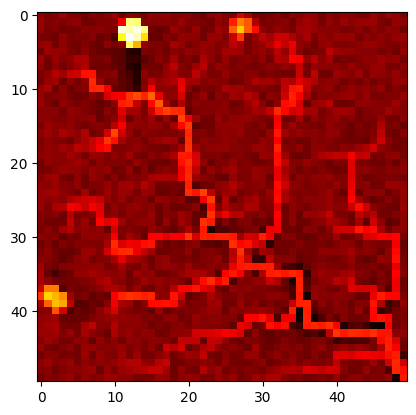

In [11]:
import matplotlib.pyplot as plt

state_vals = torch.matmul(theta, torch.transpose(all_features, 0, 1))
state_vals = torch.reshape(state_vals, (GRID_SIZE, GRID_SIZE))

plt.imshow(state_vals.cpu().numpy(), cmap="hot", interpolation="nearest")
plt.show()